In [1]:
import matplotlib.pyplot as plt
import torch
from torch.autograd import grad, Variable
import autograd
import autograd.numpy as np
import copy
import scipy as sp
from scipy import stats
from sklearn import metrics
import sys
import ot
import gwot
from gwot import models, sim, ts, util
import gwot.bridgesampling as bs

import models
import random

[KeOps] Warning : omp.h header is not in the path, disabling OpenMP. To fix this, you can set the environment
                  variable OMP_PATH to the location of the header before importing keopscore or pykeops,
                  e.g. using os.environ: import os; os.environ['OMP_PATH'] = '/path/to/omp/header'
[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float64)
torch.set_num_threads(16)

In [3]:
PLT_CELL = 2.5

In [4]:
# set random seed
SRAND = 0
torch.manual_seed(SRAND)
np.random.seed(SRAND)
# setup simulation parameters
dim = 10 # dimension of simulation
sim_steps = 250 # number of steps to use for Euler-Maruyama method
T = 10 # number of timepoints
D = 1.0 # diffusivity
t_final = 0.5 # simulation run on [0, t_final]
N = 50

In [5]:
# setup potential function
def Psi(x, t, dim = dim):
    x0 = 1.4*np.array([1, 1] + [0, ]*(dim - 2))
    x1 = -1.25*np.array([1, 1] + [0, ]*(dim - 2))
    return 1.25*np.sum((x - x0)*(x - x0), axis = -1) * np.sum((x - x1)*(x - x1), axis = -1) + 10*np.sum(x[:, 2:]*x[:, 2:], axis = -1)
# get gradient 
dPsi = autograd.elementwise_grad(Psi)

In [6]:
# branching rates
R = 10
beta = lambda x, t: R*((np.tanh(2*x[0]) + 1)/2)
delta = lambda x, t: 0
r = lambda x, t: beta(x, t) - delta(x, t)

In [7]:
# function for particle initialisation
ic_func = lambda N, d: np.random.randn(N, d)*0.1

# setup simulation object
sim = gwot.sim.Simulation(V = Psi, dV = dPsi, birth_death = True, 
                          birth = beta,
                          death = delta,
                          N = np.repeat(N, T),
                          T = T, 
                          d = dim, 
                          D = D, 
                          t_final = t_final, 
                          ic_func = ic_func, 
                          pool = None)

# sample from simulation
sim.sample(steps_scale = int(sim_steps/sim.T), trunc = N);

Text(0, 0.5, 'dim 1')

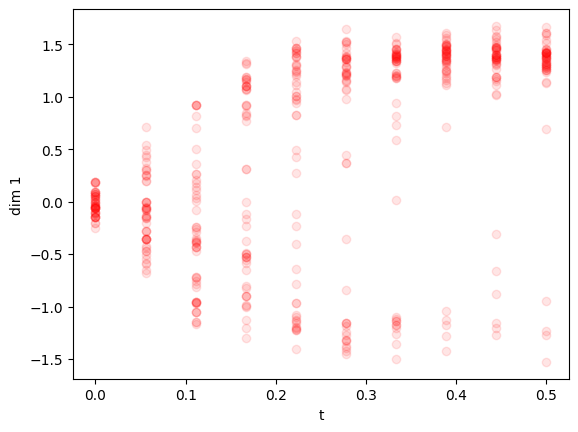

In [8]:
plt.scatter(np.kron(np.linspace(0, t_final, T), np.ones(N)), sim.x[:, 0], alpha = 0.1, color = "red")
plt.xlabel("t"); plt.ylabel("dim 1")

In [9]:
X_obs = torch.tensor(sim.x, device = device) 
t_idx_obs = torch.tensor(sim.t_idx, device = device)

M = 100
X0 = torch.randn(T, M, dim)*0.1
R_func = lambda x: R*((torch.tanh(2*x[:, 0]) + 1)/2)

In [10]:
normalize = lambda x: x/x.sum()

In [11]:
model = models.TrajLoss(X0.clone(), X_obs, t_idx_obs, dt = t_final/T, tau = D, 
                        sigma = None, M = M, lamda_reg = 0.025, lamda_cst = 0, sigma_cst = float("Inf"), 
                        branching_rate_fn = R_func,
                        sinkhorn_iters = 250, device = device, warm_start = True, 
                        lamda_unbal = None)
# model.w[0] *= 2
# model.w[-1] *= 2
# model.w = normalize(model.w)

In [12]:
output = models.optimize(model, n_iter = 2_500, eta_final = 0.1, tau_final = D, sigma_final = 0.5, temp_init = 1.0, temp_ratio = 1.0, N = M, dim = dim, tloss = model, print_interval = 50);
# output2 = models.optimize(model, n_iter = 250, tau_final = 0.5, sigma_final = np.sqrt(D), eta_final = 0.5, temp_range = (1, 1), N = M, dim = dim, tloss = model, print_interval = 50);

Iteration 0, Loss = 3.636, Primal loss = 7.048, Avg. iters = 1.000, eta = 0.100, temp = 1.000
Iteration 50, Loss = 1.947, Primal loss = 3.456, Avg. iters = 22.333, eta = 0.100, temp = 1.000
Iteration 100, Loss = 1.795, Primal loss = 3.308, Avg. iters = 46.444, eta = 0.100, temp = 1.000
Iteration 150, Loss = 1.688, Primal loss = 3.175, Avg. iters = 39.000, eta = 0.100, temp = 1.000
Iteration 200, Loss = 1.619, Primal loss = 3.127, Avg. iters = 53.222, eta = 0.100, temp = 1.000
Iteration 250, Loss = 1.511, Primal loss = 3.114, Avg. iters = 61.333, eta = 0.100, temp = 1.000
Iteration 300, Loss = 1.495, Primal loss = 3.103, Avg. iters = 54.778, eta = 0.100, temp = 1.000
Iteration 350, Loss = 1.457, Primal loss = 3.046, Avg. iters = 52.889, eta = 0.100, temp = 1.000
Iteration 400, Loss = 1.468, Primal loss = 3.069, Avg. iters = 35.778, eta = 0.100, temp = 1.000
Iteration 450, Loss = 1.407, Primal loss = 3.066, Avg. iters = 62.333, eta = 0.100, temp = 1.000
Iteration 500, Loss = 1.391, Prima

In [13]:
R_func_null = lambda x: 0*((torch.tanh(2*x[:, 0]) + 1)/2)
model_null = models.TrajLoss(X0.clone(), X_obs, t_idx_obs, dt = t_final/T, tau = D, 
                        sigma = None, M = M, lamda_reg = 0.025, lamda_cst = 0, sigma_cst = float("Inf"), 
                        branching_rate_fn = R_func_null,
                        sinkhorn_iters = 250, device = device, warm_start = True, 
                        lamda_unbal = None)

# model_null.w[0] *= 2
# model_null.w[-1] *= 2
# model_null.w = normalize(model_null.w)

In [ ]:
output_null = models.optimize(model_null, n_iter = 2_500, eta_final = 0.1, tau_final = D, sigma_final = 0.5, temp_init = 1.0, temp_ratio = 1.0, N = M, dim = dim, tloss = model, print_interval = 50);
# output2_null = models.optimize(model_null, n_iter = 250, tau_final = 0.5, sigma_final = np.sqrt(D), eta_final = 0.5, temp_range = (1, 1), N = M, dim = dim, tloss = model, print_interval = 50);

Iteration 0, Loss = 3.636, Primal loss = 7.048, Avg. iters = 1.000, eta = 0.100, temp = 1.000
Iteration 50, Loss = 2.103, Primal loss = 3.561, Avg. iters = 18.556, eta = 0.100, temp = 1.000
Iteration 100, Loss = 1.973, Primal loss = 3.393, Avg. iters = 34.333, eta = 0.100, temp = 1.000
Iteration 150, Loss = 1.812, Primal loss = 3.271, Avg. iters = 39.333, eta = 0.100, temp = 1.000
Iteration 200, Loss = 1.750, Primal loss = 3.192, Avg. iters = 42.889, eta = 0.100, temp = 1.000
Iteration 250, Loss = 1.718, Primal loss = 3.166, Avg. iters = 47.778, eta = 0.100, temp = 1.000
Iteration 300, Loss = 1.705, Primal loss = 3.128, Avg. iters = 46.556, eta = 0.100, temp = 1.000
Iteration 350, Loss = 1.622, Primal loss = 3.145, Avg. iters = 37.778, eta = 0.100, temp = 1.000
Iteration 400, Loss = 1.587, Primal loss = 3.102, Avg. iters = 39.556, eta = 0.100, temp = 1.000
Iteration 450, Loss = 1.549, Primal loss = 3.060, Avg. iters = 37.111, eta = 0.100, temp = 1.000
Iteration 500, Loss = 1.559, Prima

In [ ]:
# model_unbal = models.TrajLoss(X0.clone(), X_obs, t_idx_obs, dt = t_final/T, sigma2 = D, 
#                         eta = None, M = M, lamda = 0.025, lamda_cst = 0, eta_cst = 5, 
#                         branching_rate = R_func,
#                         n_sinkhorn_iter = 250, device = device, warm_start = True, 
#                         unbalanced_lamda = 10.0)
# model.w[0] *= 2
# model.w[-1] *= 2
# model.w = normalize(model.w)

In [ ]:
# output = models.optimize(model_unbal, n_iter = 2_500, tau_final = 0.1, sigma_final = np.sqrt(D), eta_final = 0.5, temp_range = (1, 1), N = M, dim = dim, tloss = model_unbal, print_interval = 50);

In [ ]:
# plt.subplot(1, 2, 1)
plt.plot(output[1])
plt.title("Objective: primal (annealing)")
# plt.subplot(1, 2, 2)
# plt.plot(output2[1])
# plt.title("Objective: primal")

In [ ]:
# plt.subplot(1, 2, 1)
plt.plot(output_null[1])
plt.title("Objective: primal (annealing)")
# plt.subplot(1, 2, 2)
# plt.plot(output2_null[1])
# plt.title("Objective: primal")

In [ ]:
u = np.full(dim, 1); u[1:] = 0
u = u/np.linalg.norm(u)

In [ ]:
plt.subplot(1, 2, 1)
with torch.no_grad():
    plt.scatter(np.kron(np.linspace(0, t_final, T), np.ones(M)), np.dot(model.x.reshape(-1, dim), u), c = np.kron(np.arange(T), np.ones(M)), alpha = 0.25)
    plt.ylim(-2.5, 2.5)
plt.subplot(1, 2, 2)
with torch.no_grad():
    plt.scatter(np.kron(np.linspace(0, t_final, T), np.ones(M)), np.dot(model_null.x.reshape(-1, dim), u), c = np.kron(np.arange(T), np.ones(M)), alpha = 0.25)
    plt.ylim(-2.5, 2.5)

In [ ]:
rownorm = lambda x: x/x.sum(1).reshape(-1, 1)
N_paths = 250
with torch.no_grad():
    paths = bs.sample_paths(None, N = N_paths, coord = True, x_all = model.x.cpu().numpy(), 
                        get_gamma_fn = lambda i : rownorm(model.loss_reg.ot_losses[i].coupling().cpu()), num_couplings = T-1)
    paths_null = bs.sample_paths(None, N = N_paths, coord = True, x_all = model_null.x.cpu().numpy(), 
                        get_gamma_fn = lambda i : rownorm(model_null.loss_reg.ot_losses[i].coupling().cpu()), num_couplings = T-1)

In [ ]:
paths_gt = sim.sample_trajectory(steps_scale = int(sim_steps/sim.T), N = N_paths)
np.mean(paths_gt[:, -1, 0] > 0)

In [ ]:
np.mean(paths[:, -1, 0] > 0)

In [ ]:
np.mean(paths_null[:, -1, 0] > 0)

In [ ]:
fig = plt.figure(figsize = (2*PLT_CELL, 1*PLT_CELL))
plt.subplot(1, 2, 1)
plt.plot(np.linspace(0, t_final, paths_gt.shape[1]), np.dot(paths_gt, u).T, color = 'k', alpha = 0.025);
# plt.scatter(np.linspace(0, t_final, T)[sim.t_idx], np.dot(sim.x, u).T, alpha = 0.25, c = sim.t_idx, marker = ".")
plt.text(0.4, 1, "%0.2f" % np.mean(paths_gt[:, -1, 0] > 0))
plt.text(0.4, -1, "%0.2f" % (1-np.mean(paths_gt[:, -1, 0] > 0)))
plt.ylim(-2, 2)
plt.xlabel("t")
plt.ylabel("$x_0$")
plt.title("Ground truth paths")

plt.subplot(1, 2, 2)
# plt.scatter(np.linspace(0, t_final, T)[sim.t_idx], np.dot(sim.x, u).T, alpha = 0.25, c = sim.t_idx, marker = ".")
im = plt.scatter(np.linspace(0, t_final, T)[sim.t_idx], np.dot(sim.x, u).T, alpha = 0.25, c = R_func(torch.tensor(sim.x)), marker = ".", cmap = "magma", vmin = 0, vmax = 12.5)
plt.ylim(-2, 2)
plt.xlabel("t")
plt.gca().get_yaxis().set_visible(False)
plt.title("Sample")
plt.tight_layout()

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.875, 0.225, 0.025, 0.625])
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_alpha(1)
cb.draw_all()
cbar_ax.set_title("$g$")

plt.savefig("fig3_growth_a.pdf")

In [ ]:
# fig = plt.figure(figsize = (2*PLT_CELL, 1*PLT_CELL))

plt.subplot(1, 2, 1)
plt.plot(np.linspace(0, t_final, paths.shape[1]), np.dot(paths, u).T, color = 'grey', alpha = 0.025);
with torch.no_grad():
    im = plt.scatter(np.kron(np.linspace(0, t_final, T), np.ones(M)), np.dot(model.x.reshape(-1, dim), u), c = np.kron(np.linspace(0, t_final, T), np.ones(M)), alpha = 0.25, marker = ".")
plt.text(0.4, 1, "%0.2f" % np.mean(paths[:, -1, 0] > 0))
plt.text(0.4, -1, "%0.2f" % (1-np.mean(paths[:, -1, 0] > 0)))
plt.ylim(-2, 2)
plt.xlabel("t")
plt.ylabel("$x_0$")
plt.title("MFL + Branching")
plt.subplot(1, 2, 2)
plt.plot(np.linspace(0, t_final, paths_null.shape[1]), np.dot(paths_null, u).T, color = 'grey', alpha = 0.025);
with torch.no_grad():
    plt.scatter(np.kron(np.linspace(0, t_final, T), np.ones(M)), np.dot(model_null.x.reshape(-1, dim), u), c = np.kron(np.linspace(0, t_final, T), np.ones(M)), alpha = 0.25, marker = ".")
plt.text(0.4, 1, "%0.2f" % np.mean(paths_null[:, -1, 0] > 0))
plt.text(0.4, -1, "%0.2f" % (1-np.mean(paths_null[:, -1, 0] > 0)))
plt.ylim(-2, 2)
plt.xlabel("t")
plt.gca().get_yaxis().set_visible(False)
plt.title("MFL")
plt.tight_layout()

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.875, 0.225, 0.025, 0.625])
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_alpha(1)
cb.draw_all()
cbar_ax.set_title("$t$")


plt.savefig("fig3_growth_b.pdf")